In [35]:
#Import libraries
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
from IPython.display import display
import ast
import seaborn as sns
from adjustText import adjust_text

#Load the CSV file into a DataFrame
df = pd.read_csv('lego_sets.csv')

#Clean data
df.drop(columns=['bricksetURL', 'thumbnailURL', 'imageURL'], inplace=True)
df['pieces'] = df['pieces'].fillna(0).astype(int)
df['minifigs'] = df['minifigs'].fillna(0).astype(int)
df['year'] = df['year'].astype(int)
df['pieces'] = df['pieces'].astype(int)
df['minifigs'] = df['minifigs'].astype(int)
df['US_retailPrice'] = pd.to_numeric(df['US_retailPrice'], errors='coerce')
df['US_retailPrice'] = df['US_retailPrice'].fillna(0)
df['agerange_min'] = df['agerange_min'].fillna(0)

#Create new df with missing values removed from relevant columns
df_full = df[(df['pieces'] > 0) & (df['minifigs'] > 0) & (df['US_retailPrice'] > 0)].copy()

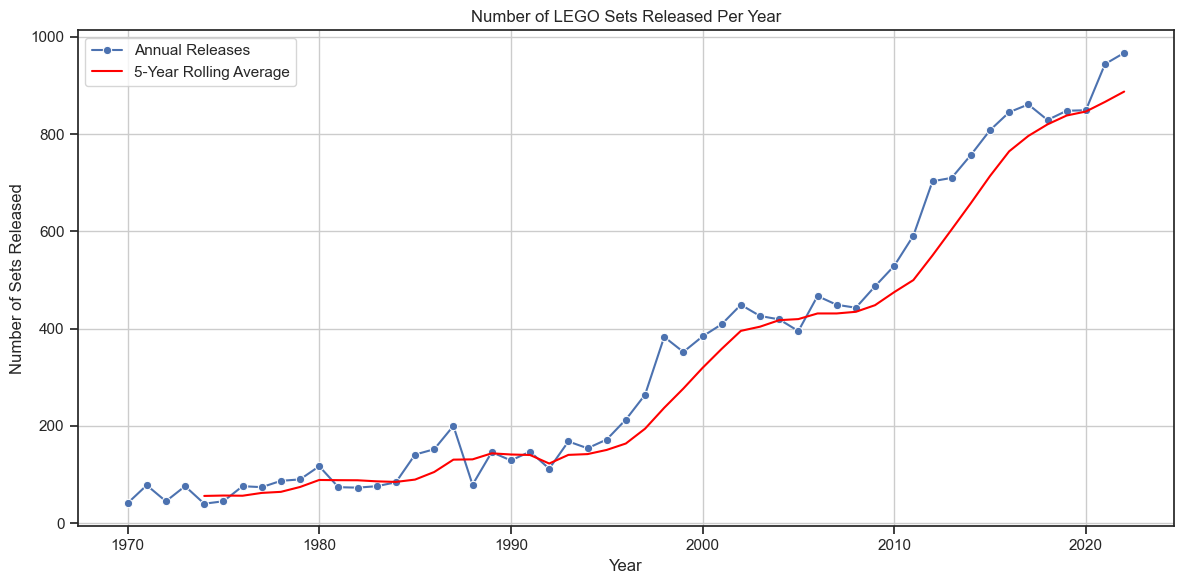

In [2]:
# Calculate a rolling average and set count
sets_per_year = df.groupby('year').size().reset_index(name='set_count')
sets_per_year['rolling_avg'] = sets_per_year['set_count'].rolling(window=5).mean()

# Plot
sns.set_theme(style='ticks')
plt.figure(figsize=(12, 6))
sns.lineplot(data=sets_per_year, x='year', y='set_count', label='Annual Releases', marker='o')
sns.lineplot(data=sets_per_year, x='year', y='rolling_avg', label='5-Year Rolling Average', color='red')

plt.title('Number of LEGO Sets Released Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Sets Released')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


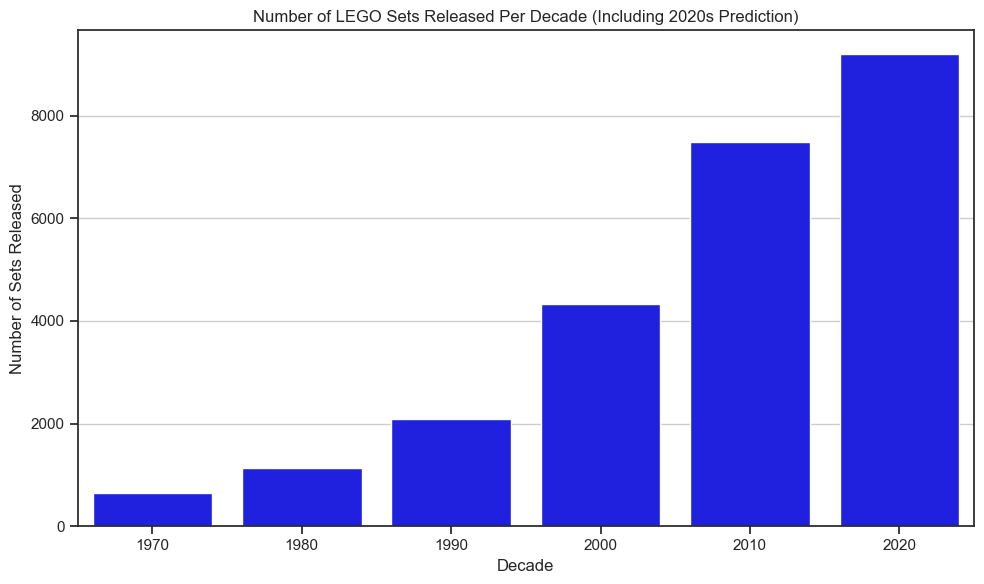

In [3]:
# Create a new column for decade
df['decade'] = (df['year'] // 10) * 10

# Count the number of sets released each decade
sets_per_decade = df.groupby('decade').size()

# Filter for 2020–2022
recent_years = df[df['year'].between(2020, 2022)]

# Average sets released per year from 2020 to 2022
avg_recent = recent_years.groupby('year').size().mean()

# Predict total for 2020s (2020–2029 = 10 years)
predicted_total_2020s = round(avg_recent * 10)

# Add predicted 2020s total to sets_per_decade
sets_per_decade_pred = sets_per_decade.copy()
sets_per_decade_pred.loc[2020] = predicted_total_2020s
# Set up data for plot
sets_per_decade_pred = sets_per_decade_pred.reset_index()
sets_per_decade_pred.columns = ['decade', 'set_count']
sets_per_decade_pred.sort_values('decade', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sets_per_decade_pred.sort_index(), x='decade', y='set_count', color='blue')

plt.title('Number of LEGO Sets Released Per Decade (Including 2020s Prediction)')
plt.xlabel('Decade')
plt.ylabel('Number of Sets Released')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

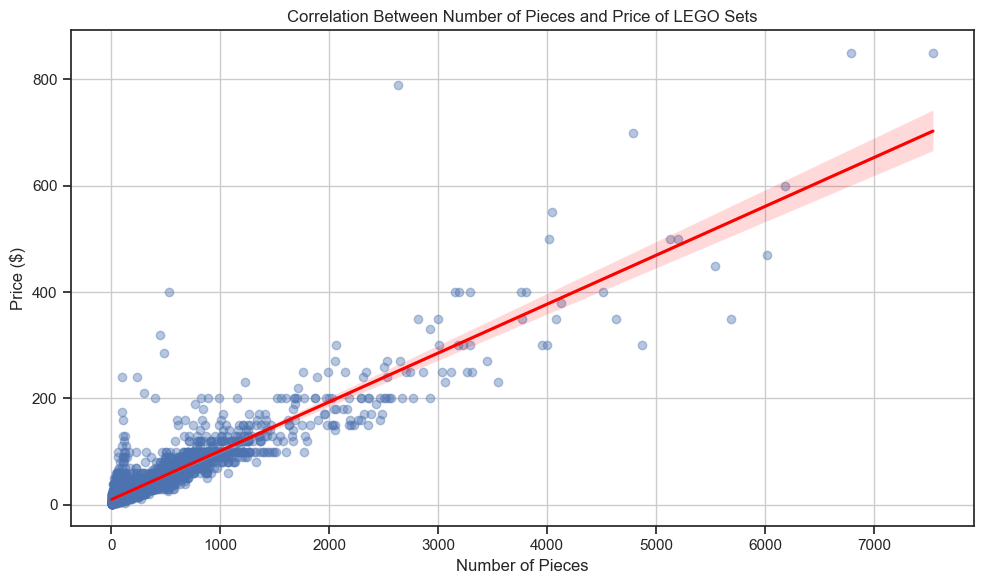

In [4]:
# Scatter plot with regression line for correlation between pieces and price
plt.figure(figsize=(10, 6))
sns.regplot(data=df_full, x='pieces', y='US_retailPrice', scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})

plt.title('Correlation Between Number of Pieces and Price of LEGO Sets')
plt.xlabel('Number of Pieces')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

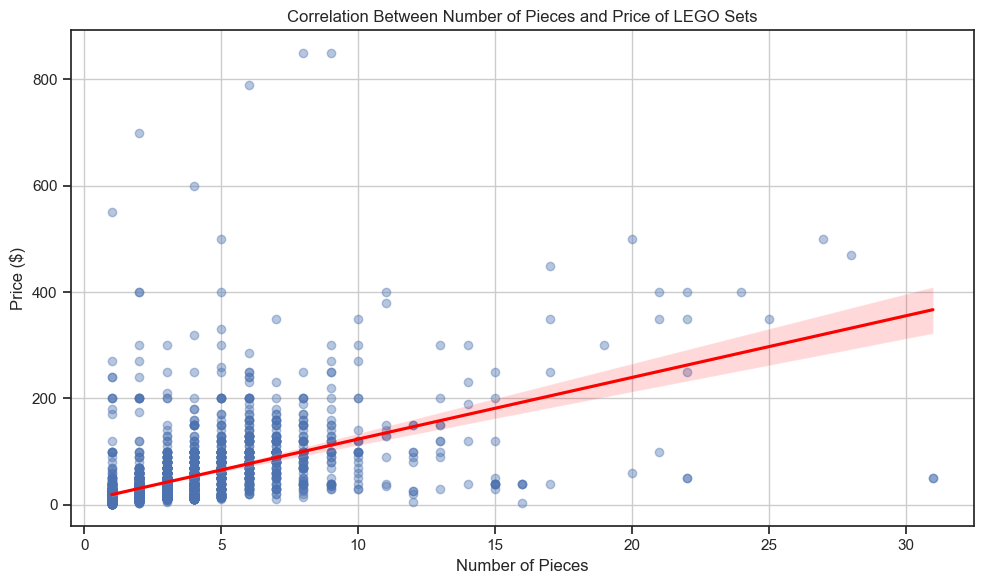

In [ ]:
# Scatter plot with regression line for correlation between pieces and price
plt.figure(figsize=(10, 6))
sns.regplot(data=df_full, x='minifigs', y='US_retailPrice', scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})

plt.title('Correlation Between Number of Pieces and Price of LEGO Sets')
plt.xlabel('Minifigures')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

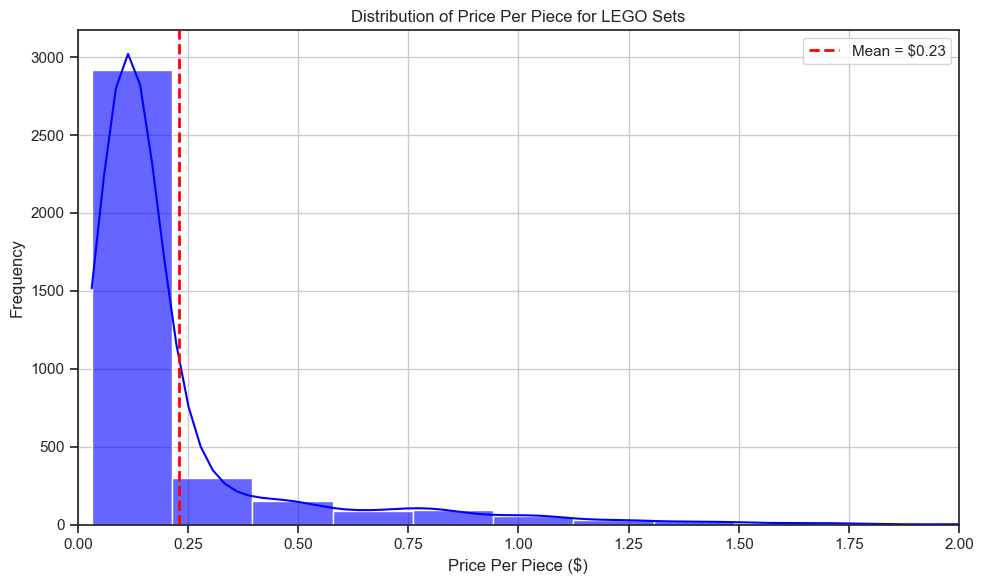

In [36]:
df_full['price_per_piece'] = df_full['US_retailPrice'] / df_full['pieces']
mean_price_per_piece = df_full['price_per_piece'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_full, x='price_per_piece', bins=30, kde=True, color='blue', alpha=0.6)
plt.axvline(mean_price_per_piece, color='red', linestyle='--', linewidth=2, label=f'Mean = ${mean_price_per_piece:.2f}')
plt.legend()
plt.xlim(0, 2)
plt.title('Distribution of Price Per Piece for LEGO Sets')
plt.xlabel('Price Per Piece ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
best_piece_value = df_full.sort_values('price_per_piece', ascending=True).head(1)
worst_piece_value = df_full.sort_values('price_per_piece', ascending=False).head(1) 
worst_piece_no_books = df_full[df_full['theme'] != 'Books'].sort_values('price_per_piece', ascending=False).head(1)


df_full['price_per_fig'] = df_full['US_retailPrice'] / df_full['minifigs']
best_fig_value = df_full.sort_values('price_per_fig', ascending=True).head(1)
worst_fig_value = df_full.sort_values('price_per_fig', ascending=False).head(1)

In [7]:
total_sets_per_decade = df.groupby('decade').size().reset_index(name='total_sets')
theme_counts = df.groupby(['decade', 'theme']).size().reset_index(name='set_count')

theme_counts_sorted = theme_counts.sort_values(['decade', 'set_count'], ascending=[True, False])
top_3_ranked = (
    theme_counts_sorted.groupby('decade')
    .head(3)
    .assign(rank=lambda df: df.groupby('decade').cumcount() + 1)
)

top_3_with_totals = top_3_ranked.merge(total_sets_per_decade, on='decade')

top_3_with_totals['entry'] = top_3_with_totals.apply(
    lambda row: f"{row['theme']} ({(row['set_count'] / row['total_sets'] * 100):.1f}%)", axis=1
)

theme_table = top_3_with_totals.pivot(index='decade', columns='rank', values='entry')
theme_table.columns = ['1st', '2nd', '3rd']

display(theme_table)

,1st,2nd,3rd
decade,,,
1970,LEGOLAND (24.4%),Samsonite (8.4%),Town (8.3%)
1980,Town (16.6%),Service Packs (14.6%),Basic (14.0%)
1990,Town (16.5%),Duplo (16.0%),Service Packs (9.7%)
2000,Gear (20.6%),Bionicle (7.9%),Duplo (7.1%)
2010,Gear (17.5%),Collectable Minifigures (8.3%),Star Wars (6.9%)
2020,Gear (21.2%),City (6.6%),Collectable Minifigures (5.5%)
